# Kapitel 5 - Evaluation

## 5.1. Kapitelübersicht <a class="anchor" id="5-1"/>

Eine Evaluation eines Klassifizierungsverfahren ist notwendig, um es bewerten und mit anderen Klassifizierungsverfahren vergleichen zu können. In diesem Kapitel gehen wir auf die verschiedenen Metriken und Ansätze ein, mit der wir ein Klassifizierungsverfahren bewerten können. Zuletzt werden wir dann ein Metrikverfahren für die restliche Tutorialreihe festlegen.

<b>Abschnittsübersicht</b><br>

[5.1. Kapitelübersicht](#5-1)<br>
[5.2. Trainings- und Testdatensatz](#5-2)<br>
[5.3. Classification accuracy](#5-3)<br>
[5.4. Confusion Matrix](#5-4)<br>
[5.5. Der F-Score](#5-5)<br>
[5.6. k-fold cross-validation](#5-6)<br>
[5.7. Evaluation in der Tutorialreihe](#5-7)<br>
[5.8. Mögliche Fehler](#5-8)<br>

Am Ende dieses Kapitel werden wir folgende Themen behandelt und/oder vertieft haben:
- Aufteilung in Trainings- und Testdatensätze 
- Aufteilung in Trainings-, Validierungs- und Testdatensätze
- Classification accuracy
- Visualisierung einer Confusion Matrix
- Der F-Score
- k-fold cross-validation

## 5.2. Trainings- und Testdatensatz <a class="anchor" id="5-2"/>

Bei den meisten Evaluationstechniken wird eine Bewertung für eine Textklassifikation berechnet, indem der Datensatz in einen <b>Trainings- und Testdatensatz</b> (auch Evaluationsdatensatz genannt) unterteilt wird. Das Klassifikationsverfahren wird dabei wie gewohnt auf den Trainingsdatensatz angewendet. Beim Testdatensatz werden die <i>Labels/ Klassen</i> (im unseren Fall die Wikipediakategorien) entfernt und das Klassifikationsmodell muss diese Labels generieren. Die generierten Labels werden dann mit den tatsächlichen Labels des Testdatensatzes verglichen. Basierend darauf wird ein <b>score</b> (deutsch: Punktzahl) berechnet, der angibt, wie gut ein erlerntes Klassifikationsmodell neue Daten klassifizieren kann.<br>
Der Testdatensatz muss dabei das gleiche Format wie der Trainingsdatensatz haben. Inhaltlich muss sich der Testdatensatz jedoch von dem Trainingsdatensatz unterscheiden, d.h. es sollen keine Teildatensätze im Testdatensatz wiederverwendet werden. Im schlimmsten Fall würden wir den Trainingsdatensatz einfach als Testdatensatz wiederverwenden und das Klassifikationsmodell würde sich einfach die Datensätze "merken". Der zentrale und wichtige Schritt der Verallgemeinerung entfällt. Dies würde zu einem sehr guten <b>Score</b> führen, der jedoch verfälscht ist. Bei der Voraussage von neuen Datensätze würde unser Klassifikationsmodell dann vermutlich sehr schlechte Voraussagen treffen, obwohl der Score sehr gut war.

#### Laden des Korpus

In [1]:
import pandas as pd
corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv", index_col=0)
corpus.head()

,id,category,length,text
0,3470,Album nach Typ,1050,All the Best ! ( englisch Alles Gute ! ) ist d...
1,3611,Album nach Typ,525,Let It Roll : Songs by George Harrison ist das...
2,3612,Album nach Typ,251,Lieder wie Orkane ist das dritte offizielle Be...
3,3613,Album nach Typ,756,Long Stick Goes Boom : The Anthology ist eine ...
4,3614,Album nach Typ,260,Los Grandes Éxitos en Español ( spanisch für D...


#### Teilung in Trainings- und Testdatensatz

Wie gewohnt kodieren und vektorisieren wir unsere Labels und unsere Textdaten. Hierbei wurde der Code dafür etwas abgekürzt.

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

labels = LabelEncoder().fit_transform(corpus["category"])
vector = TfidfVectorizer().fit_transform(corpus["text"])

Nun schauen wir uns die Dimensionen der Matrix unseres vektorisierten Textes an. `shape` gibt uns die Dimensionen der Matrix als Tupel `(n,m)` zurück. `n` steht für die Zeilen der Matrix, `m` für die Spalten. 

In [3]:
vector.shape

(6000, 281396)

Nun wollen wir diese Daten teilen. Da eine Zeile für einen Wikipediaartikel steht, müssen wir uns an der ersten Zahl im Tupel orientieren. Das Verhältnis, wie wir die Daten teilen, soll hier 80% Trainingsdaten und 20% Testdaten sein. Die Bezeichnung "X" für die Textdaten und die Bezeichnung "y" für die Labels ist typisch und wird auch so von Scikit learn in der Dokumentation genutzt. Dass das X großgeschrieben wird ist eine Konvention, die zeigt, dass es sich hier um eine Matrix handelt. Vektoren wie y werden kleingeschrieben.

In [4]:
X_train = vector[:int(6000*0.8)]
y_train = labels[:int(6000*0.8)]
X_test = vector[int(6000*0.8):]
y_test = labels[int(6000*0.8):]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4800, 281396)
(4800,)
(1200, 281396)
(1200,)


<div class="alert alert-info">
<b>Exkurs:</b> Verhältnis von Trainings- und Testdaten
    
Bei dem Verhältnis von Trainings- und Testdaten sollte der Anteil der Trainingsdaten immer größer sein als die Anzahl der Testdaten. Ein Modell trainiert nur auf den Trainingsdaten, der Testdatensatz dient nur der Evaluation. Bei einem zu kleinen Anteil des Trainingsdatensatzes könnte das Modell zu wenig lernen, obwohl eigentlich genug Daten zur Verfügung stehen würden.<br>
Eine typische Aufteilung ist 80% Trainingsdaten und 20% Testdaten. Diese Aufteilung nennt sich auch das <a href="https://de.wikipedia.org/wiki/Paretoprinzip">Paretoprinzip</a>. Der KI-Experte Andrew Ng empfiehlt für sehr große Korpora (ab etwa einer Millionen Datensätze) eine Aufteilung von 98/2 oder sogar 99.5/0.5. 

</div>

Für die Einteilung gibt es eine von Scikit learn integrierte Funktion `train_test_split`, die die Daten in zufällige Trainings- und Testdatensätze unterteilt. Dort kann man das Verhältnis des Trainings- und Testdatensatzes (`train_size`, `test_size`) angeben, die einzelnen Daten mischen, bevor sie geteilt werden (`shuffle=False`) oder einen Seed für den Zufallsgenerator setzen (`random_state`). Der Parameter `train_size` muss nur zwingend angegeben werden, wenn es `test_size` nicht ergänzen soll (also beide zusammen nicht 1.0 ergeben sollen). Im Folgenden wird für die restliche Tutorial-Reihe immer die Zahl "42" für den Parameter `random_state` gewählt (außer eine Änderung wird explizit erwähnt), damit die Ergebnisse reproduzierbar sind. Die Zahl selbst ist dabei eigentlich egal, solange sie immer die gleiche ist.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    train_size=0.8,
                                                    random_state=42)

Nun setzen wir unsere Daten in unser Klassifizierungsverfahren ein. Anstatt den vektorisierten Daten `vector` und den kodierten Labels `labels` übergeben wir nun die vektorisierten Trainingsdaten `X_train` und die kodierten Trainingslabels `y_train`. Die Variable `y_pred` enthält die Voraussagen, die das Klassizierungsverfahren anhand der Trainingsdaten auf die Testdaten getroffen hat. Um zu sehen, wieviele Labels richtig zugeordnet wurden, berechnen wir das <b>arithmetische Mittel</b> der Vektoren `y_pred` und `y_test`. Der Mittelwert gibt hier an, wieviel Prozent der Labels richtig zugeordnet wurden. 

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

import numpy as np


# Multinomial Naive Bayes
classifier = MultinomialNB()
mnb = classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

print(np.mean(y_pred == y_test))

0.87


<div class="alert alert-info">
<b>Exkurs:</b> Arithmetisches Mittel
    
Das <b>Arithmetische Mittel</b> ist eines der drei Varianten des <b>Mittelwerts</b>. Es wird berechnet, indem alle gegebenen Werte durch die Anzahl der Werte geteilt werden.<br><br>

$ \overline{x} = \frac{1}{n} \sum\nolimits_{i=1}^n x_i = \frac{x_1 + x_2 + ... + x_n}{n} $ 

</div>

## 5.3. Classification accuracy <a class="anchor" id="5-3"/>

Die <b>Classification accuracy</b> (oder auch nur <b>accuracy</b>) ist ein Maß zur Bewertung von Klassifikationsverfahren. Sie wird folgendermaßen berechnet:<br>

<u>Formel (allgemein)</u>:<br>
$  \text{Classification accuracy} = \frac{\text{Anzahl der korrekten Voraussagen}}{\text{Gesamtanzahl aller Voraussagen}} $<br>

<u>Formel (mathematisch)</u>:<br>
$\text{Classification accuracy}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples}-1} 1(\hat{y}_i = y_i)$ [<sup>1</sup>](#fn1)<br><br>

Die Formel scheint auf dem ersten Blick dem <b>arithmetischen Mittel</b> zu ähneln, hat aber einen entscheidenden Unterschied:
- Das <b>Arithmetische Mittel</b> ist ein Maß, das den <i>Durchschnitt</i> einer Reihe von Zahlen angibt.
- Die <b>Classification Accuracy</b> ist ein Maß, das zwei Zahlenreihen miteinander <i>vergleicht</i> und angibt, wie hoch die Übereinstimmung ist.

<u>Beispiel</u>:<br>
Zwei kodierte Labelvektoren werden miteinander verglichen. Es soll berechnet werden, wieviele gemeinsame Labels die beiden Vektoren haben. Haben sie ein gemeinsames Label, erhält die Schnittstelle den Wert "1", ansonsten eine "0".<br>
$ v_1 = (1, 1, 2, 5, 3, 4, 4) $<br>
$ v_2 = (1, 2, 2, 5, 4, 4, 3) $<br>

$ \text{Alle Voraussagen:}\ 1==1,\ 1==2,\ 2==2,\ 5==5,\ 3==4,\ 4==4,\ 4==3 $<br>
$ \text{Anzahl der korrekten Voraussagen:}\ 1 + 0 + 1 + 1 + 0 + 1 + 0 = 4 $<br>
$ \text{Gesamtanzahl aller Voraussagen:}\ 7 $<br>

$ \text{Classification accuracy} = \frac{4}{7} = 0.57$<br>

<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">1</sup> &nbsp; Siehe <a href="https://scikit-learn.org/stable/modules/model_evaluation.html">https://scikit-learn.org/stable/modules/model_evaluation.html</a> (abgerufen am 03.09.2019).</span>

In Scikit learn wird die Classification accuracy folgendermaßen berechnet.

In [7]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.87


Die Classification accuracy ist nur bedingt als Evaluationsmaß nützlich. Wichtige Details, die zum besseren Verständnis der Leistung eines Klassifikationsmodell nötig wären, werden ausgeblendet. Dies wird in zwei Fällen deutlich:<br>
1. Sogenannte <b>unausgeglichen Datensätzen</b> (englisch: imbalanced datasets), bei denen die Daten keine gerade Anzahl an Klassen haben, sind problematisch: Ist die Classification accuracy 90%, aber 90 von 100 Datensätzen sind einer Klasse zugeordnet, kann genau die gleiche Genauigkeit auch erreicht werden, wenn man einfach für jeden Datensatz die häufigste Klasse voraussagt.[<sup>2</sup>](#fn2) Die accuracy scheint hoch zu sein, im Hinblick auf die Verteilung der Klassen ist sie jedoch nicht besonders gut.
2. Bei der <b>Multiclass classification</b> kann bei einem Ergebnis von z.B. 85% nicht gesagt werden, ob alle Klassen gleich gut vorhergesagt wurden oder ob eine oder zwei Klassen vom Klassifizierungsmodell vernachlässigt wurden.
 

Unser Datensatz ist ausgeglichen, da zu jeder Kategorie gleich viele Artikel gehören (immer genau 200 Artikel). Jedoch benutzen wir Multiclass classification, weshalb die Classification accuracy als Evaluationsmethode für unseren Datensatz nicht uneingeschränkt genutzt werden kann.

<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">2</sup> &nbsp; Dieses Problem wird auch <a href=https://en.wikipedia.org/wiki/Accuracy_paradox>Accuracy paradox</a> genannt. Ein sehr anschauliches Beispiel dafür bietet dieser <a href="https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c">Medium-Artikel</a>.</span>

## 5.4. Confusion Matrix <a class="anchor" id="5-4"/>

Eine Möglichkeit, die Ergebnisse der Voraussagen eines Klassifikationsverfahren zu visualisieren, ist eine <b>Confusion Matrix</b> (deutsch: Wahrheitsmatrix). Diese Matrix ist ein spezifisches Tabellenlayout, bei der die Anzahl der korrekten und inkorrekten Vorhersagen mit Zählwerten zusammengefasst und anhand der Klassen aufgeteilt wird.<br>

> The confusion matrix shows the ways in which your classification model is confused when it makes predictions."[<sup>3</sup>](#fn3) - <i>Jason Brownlee</i>
    

<hr style="border: 0.1px solid black;"/>
<span id="fn1" style="font-size:8pt; line-height:1"><sup style="font-size:5pt">3</sup> &nbsp; Siehe den Blogeintrag <a href="https://machinelearningmastery.com/confusion-matrix-machine-learning/">What is a Confusion Matrix in Machine Learning</a>.</span>    


<div class="alert alert-warning">
<b>Aufgabe:</b> Confusion Matrix für 2 Klassen
    
Die Aufgabe ist es, den <a href="https://machinelearningmastery.com/confusion-matrix-machine-learning/">Blog-Eintrag</a> von Jason Brownlee über Confusion Matrizen für 2 Klassen zu lesen. Besonders soll dabei auf die <b>True Positives</b>, <b>True Negatives</b>, <b>False Positives</b> und <b>False Negatives</b> geachtet werden. Sollte dies durch den Blog-Eintrag nicht verständlich genug erklärt werden, können folgende Informationsquellen hinzugezogen werden:
- Eine gute deutschsprachige Erklärung (für Besitzer des Buches oder für Studierende, bei denen das Buch/E-Book in der Bibliothek verfügbar ist): KLINKE, Harald, "Information Retrieval", in: Fotis JANNIDIS/ Hubertus KOHLE/ Malte REHBEIN, Digital Humanities. Eine Einführung, Stuttgart 2017, S. 268-278, 269.
- Eine weiterer englischsprachiger Blog-Eintrag: https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/
- Der englische Wikipediaartikel zur Confusion Matrix: https://en.wikipedia.org/wiki/Confusion_matrix

</div>

Um die Confusion Matrix für mehr als 2 Klassen zu verstehen, soll sie zunächst erzeugt werden. In Scikit learn ist eine Confusion Matrix Visualisierung implementiert, die jedoch nicht besonders anschaulich ist.

In [8]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix[:10] #verkürzte Darstellung, damit der Output nicht zu groß wird

array([[46,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 43,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 51,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0, 29,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  2,  0,  0, 20,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,
         7, 10,  0,  0,  0,  0,  0,  0,  1,  0,  7,  0,  0,  3],
       [ 0,  0,  0,  0,  0,  0, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0, 41,  

Wir verwenden lieber die Python Visualisierungsbibliothek <b>Seaborn</b> zur Darstellung der Confusion Matrix. Die Funktion <a href="https://seaborn.pydata.org/generated/seaborn.heatmap.html">heatmap</a> erzeugt dabei eine anschaulichere Confusion Matrix. Dafür müssen wir ihr nur ein DataFrame übergeben, welches die Confusion Matrix als Input hat und als Reihen und Spalten die verschiedenen Kategorienbezeichnungen (hier `classes` genannt) übergeben bekommt.

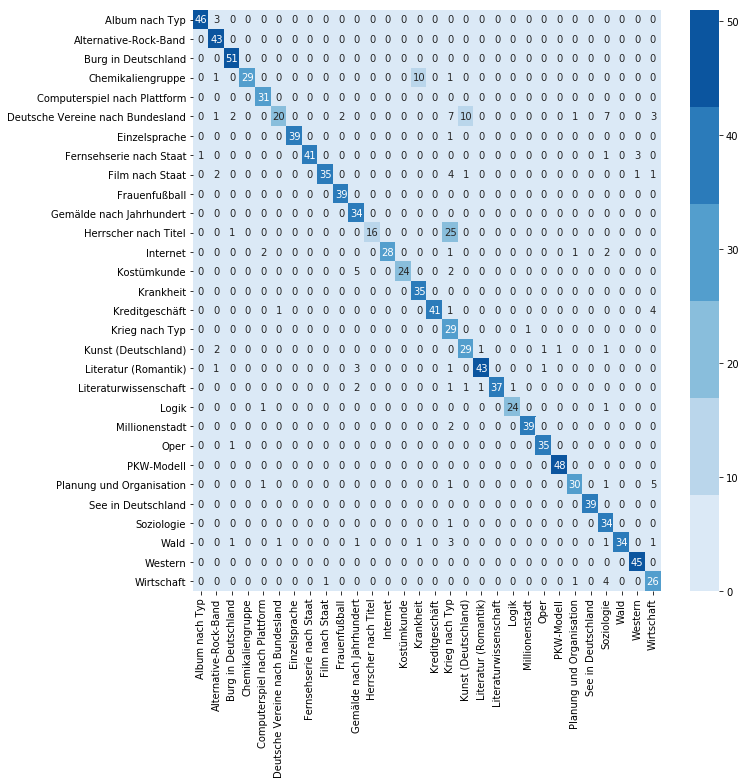

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Die Original Kategorienbezeichnungen
classes = corpus["category"].drop_duplicates().tolist()

# Ein DataFrame mit den Kategorienbezeichnungen als Reihen und Spalten
cnf_df = pd.DataFrame(cnf_matrix, index=classes, columns=classes)
    
plt.figure(figsize=(11, 11))
sns.heatmap(cnf_df, annot=True, cmap=sns.color_palette("Blues"))
plt.tight_layout()

Die vertikal Achse zeigt die "wahren" Kategorien aus dem Testdatensatz an (`y_test`) und die horizontale Achse zeigt die Kategorien an, die von `y_pred` vorausgesagt wurden. Die Diagonale zeigt hier an, welche Kategorien richtig zugeordnet wurden. So wurde "Album nach Typ" 46 Mal richtig der Kategorie "Album nach Typ" zugeordnet. Man kann hier sehr gut falsche Klassifikationen erkennen. Umso mehr Kategorien einer anderen Kategorie zugeordnet wurden, umso dunkler ist der Farbton. So sticht sofort die fehlerhafte Klassifizierung von "Herrscher nach Titel" auf. Nur 16 Mal wurde diese Kategorie richtig klassifiziert, 25 Mal wurde sie fälschlicherweise der Kategorie "Krieg nach Typ" zugeordnet. Bei einer idealen Multiclass Confusion Matrix wären die Felder der Diagonalen die einzigen Felder, die nicht aus 0en bestehen würden.

## 5.5. Der F-score <a class="anchor" id="5-5"/>

Der <b>F1-score</b> oder auch nur <b>F-score</b> (deutsch: F-Maß) ist wie die <b>Classification Accuracy</b> ein Maß zur Bewertung von Klassifikationsverfahren. Es ist das harmonische Mittel zwischen <b>Precision</b> und <b>Recall</b>. Die Precision zeigt an, wie <i>exakt</i> ein Klassifikationsverfahren klassifiziert und der Recall zeigt an, wie <i>vollständig</i> die Klassifizierungen des Klassifikationsverfahren sind. Sie werden folgendermaßen berechnet:<br>

$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives}\ +\ \text{False Positives}}$<br>

$ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives}\ +\ \text{False Negatives}}$<br>

Im Falle unserer Confusion Matrix aus dem vorherigen Abschnitt zeigen die Zeilenwerte einer Kategorie die <b>False Positives</b> Werte an und die Spaltenwerte der entsprechenden Kategorie die <b>False Negatives</b> an. Der Wert in der Zelle, bei der die Kategorie der horizontalen und vertikalen Achse gleich ist, ist der <b>True Positive</b>.<br>

Setzen wir die Werte einmal für die Kategorie "Album nach Typ" ein:<br>
$ \text{Precision}_\text{Album nach Typ} = \frac{46}{46\ +\ 3} = 0.9387$<br>

$ \text{Recall}_\text{Album nach Typ} = \frac{46}{46\ +\ 1} = 0.9787$<br>

Die Precision und Recall Werte liegen immer zwischen 0 und 1, wobei die Tendenz gegen 0 ein schlechter Precision oder Recall Wert ist und die Tendenz gegen 1 ein guter Precision oder Recall Wert ist.<br>

Der <b>F1-score</b> wird folgendermaßen berechnet:<br>

$ \text{F1-score} = 2 \cdot \frac{\text{Precision}\ \cdot\ \text{Recall}}{\text{Precision}\ +\ \text{Recall}}$<br>

Der F1-score für die Kategorie "Album nach Typ" ist also $ 2 \cdot \frac{0.9387\ \cdot\ 0.9787}{0.9387\ +\ 0.9787} = 2 \cdot \frac{0.9187}{1.9174} = 0.9582$<br>

Der F1-score hat anders als die Classification Accuracy kein Problem mit unausgeglichen Datensätzen. Obwohl unser Datensatz ausgeglichen ist, werden wir in den folgenden Kapitel trotzdem den F1-score als Bewertungsmaß für unsere Textklassifizierungsverfahren verwenden.

#### Implementierung in Scikit learn

Der F1-score wird in Scikit learn mit der Funktion `f1_score` implementiert. Bei einer Multiclass Klassifikation ist der F1-score der durchschnittliche F1-score aller Klassen. Dieser Durchschnitt kann gewichtet werden mit dem `average`-Parameter. <b>Vorsicht</b>: Der Standardwert ist "binary", der jedoch nur für eine binäre Klassifikation gedacht ist. Bei einer Multiclass Klassifikation muss der `average`-Parameter immer angegeben werden. Die verschiedenen Parameterwerte sind in der <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score">Dokumentation</a> aufgelistet. Wir haben hier den `micro`-Durchschnitt verwendet und werden diesen auch für die restliche Tutorialreihe verwenden, sofern es nicht anders angegeben wird.

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

labels = LabelEncoder().fit_transform(corpus["category"])
vector  = TfidfVectorizer().fit_transform(corpus["text"])


X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    train_size=0.8,
                                                    random_state=42)


# Multinomial Naive Bayes
classifier = MultinomialNB()
mnb = classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

f1 = f1_score(y_test, y_pred, average="micro")
print(f"Der F1-score für die Klassifizierung mit Multinomial Naive Bayes ist {str(f1)}.")

Der F1-score für die Klassifizierung mit Multinomial Naive Bayes ist 0.87.


Scikit learn bietet mit dem <b>Classification Report</b> eine Möglichkeit, die einzelnen Precision, Recall und F1-Score Werte für jede einzelne Klasse anzuzeigen. Dort können auch die verschiedenen Average-Parameter (`"micro"`, `"macro"`, `"weighted"`) des F1-scores angesehen und verglichen werden. Es wird empfohlen, die Liste der Klassen dem `target_names` Parameter zu übergeben, da die numerische Repräsentation den Klassen nicht unbedingt informativ ist.

In [19]:
from sklearn.metrics import classification_report
classes = corpus["category"].drop_duplicates().tolist()
print(classification_report(y_test, y_pred, target_names=classes))

                                  precision    recall  f1-score   support

                  Album nach Typ       0.98      0.94      0.96        49
           Alternative-Rock-Band       0.81      1.00      0.90        43
             Burg in Deutschland       0.91      1.00      0.95        51
               Chemikaliengruppe       1.00      0.71      0.83        41
    Computerspiel nach Plattform       0.89      1.00      0.94        31
Deutsche Vereine nach Bundesland       0.91      0.38      0.53        53
                   Einzelsprache       1.00      0.97      0.99        40
         Fernsehserie nach Staat       1.00      0.89      0.94        46
                 Film nach Staat       0.97      0.80      0.88        44
                   Frauenfußball       0.95      1.00      0.97        39
        Gemälde nach Jahrhundert       0.76      1.00      0.86        34
            Herrscher nach Titel       1.00      0.38      0.55        42
                        Internet     

## 5.6. k-fold cross validation <a class="anchor" id="5-6"/>

Die <b>cross validation</b> (deutsch: Kreuzvalidierungsverfahren) ist ein Verfahren zur Bewertung des Umgangs eines Klassifikationsmodells mit ungesehenen Daten, d.h. die wie gut das Klassifikationsmodell anhand eines unabhängigen Datensatzes <i>verallgemeinern</i> kann. Dadurch soll <b>overfitting</b> vermieden werden.

<div class="alert alert-info">
<b>Exkurs:</b> Overfitting und Underfitting
    
<b>Overfitting</b> (deutsch: Überanpassung) ist eines der zentralen Probleme von Machine Learning. Das Ziel eines Machine Learning Algorithmus ist es, Informationen aus Daten zu lernen und diese Informationen zu <b>verallgemeinern</b>. Schafft es ein Modell nicht zu verallgemeinern, kommt es zu <b>Overfitting</b>. Dies macht sich bei der Evaluierung bemerkbar: Das Modell liefert sehr gute Werte bei den Trainingsdatensätzen, bei den Testdatensätzen jedoch sehr schlechte Werte oder einen Wert, der stark vom Wert des Trainingsdatensatz abweicht.<br>

Ein Machine Learning Modell kann auch "underfitten". Das Modell hat zu sehr verallgemeinert, weshalb es sein gelerntes "Wissen" aus dem Trainingsdatensatz nicht auf den Testdatensatz anwenden kann. "Overfitting" und "Underfitting" kann mit den verschiedensten Techniken bekämpft werden. Für weitere Informationen zu Over- und Underfitting siehe den <a href="https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/">Blog-Eintrag</a> von Jason Brownlee.

</div>

Cross validation ist eine Alternative zur Aufteilung des Datensatzes in Trainings- und Testdatensätze, was wir in Abschnitt 5.2 gesehen haben. Bei einer cross validation wird der Datensatz in <i>k</i>-1 Trainingsdatensätze und einen Testdatensatz aufgeteilt. Es wird solange ein neuer Trainingsdurchlauf durchgeführt, bis jeder Teildatensatz (= <i>fold</i>) einmal die Rolle des Testdatensatzes innehatte. Der Wert <i>k</i> gibt die Anzahl der Durchläufe und die Anzahl der Teildatensätze an. Auf dem folgenden Bild ist <i>k</i> = 5.<br><br>
<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="k-fold cross validation graphic" style="width: 350px;" align="left"/>

Nach der cross validation haben wir <i>k</i>-scores, die man mit einem <b>Mittelwert</b> oder einer <b>Standardabweichung</b> zusammenfassen kann. Der Ergebniswert zeigt uns, wie zuverlässig unser Klassifikationsmodell neue Daten klassifizieren kann.

#### Implementierung in Scikit learn

In Scikit learn wird die cross validation mit der Funktion `cross_val_score` implementiert. Dieser Funktion wird der Classifier, die vektorisierten Textdaten und die Labels übergeben. Der Parameter `cv` gibt <i>k</i> an, solange wir ihm einen Integer übergeben. Je größer `cv` ist, desto länger dauert die cross validation. Übliche Parameter sind 3, 5 oder 10. 

In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(classifier, vector, labels, cv=3)
np.mean(scores)

0.8589602492587568

## 5.7. Evaluation in der Tutorialreihe <a class="anchor" id="5-7"/>

Es stellt sich nun die Frage, wie wir die Klassifizierungsverfahren in unserer Tutorialreihe bewerten. Die <b>cross validation</b> ist der Gold Standard für die Performance Evaluierung eines Machine Learning Algorithmus. Anders als im vorherigen Abschnitt werden wir die cross validation nur auf einem Trainingsdatensatz ausführen. Unser Datensatz ist groß genug, um ihn in Trainings- und Testdatensätze zu teilen, ohne dass der Trainingsdatensatz dadurch zu klein wird, um ihn effektiv trainieren zu können. Der Testdatensatz wird mit dem <b>F1-score</b> evaluiert. Nun haben wir jedoch 2 Testdatensätze. Der eine Testdatensatz wird manuell von uns mithilfe von `train_test_split` aus dem Datensatz extrahiert, der andere wird immer wieder von der cross validation erzeugt. Im Bereich des Machine Learning werden deshalb diese beiden Testdatensätze unterschieden. Der <b>Testdatensatz</b> wird erst für die Evaluierung des finalen Modells genutzt. Der <b>Validierungsdatensatz</b> (englisch: validation data) wird zur Evaluierung des Klassifikationsmodells während der Anpassung der Parameter benutzt. Diese Parameter passen wir bei der <b>k-fold cross validation</b> an, weshalb wir eigentlich keinen eigenständigen oder festen Validierungsdatensatz haben, da dieser bei jedem Durchgang neu bestimmt wird. Im Bereich des <b>Deep Learning</b>, welches in späteren Kapiteln aufgegriffen wird, werden wir jedoch noch Anwendungen für den Validierungsdatensatz kennen lernen.

<div class="alert alert-warning">
<b>Aufgabe:</b> Unterschied von Trainings-, Validierungs- und Testdatensätzen
    
Die Aufgabe ist es, den <a href="https://machinelearningmastery.com/difference-test-validation-datasets/">Blog-Eintrag</a> von Jason Brownlee über den Unterschied von Trainings-, Validierungs- und Testdatensätze zu lesen.

</div>

Die Evaluation eines Klassifikationsverfahren wird in unserer Tutorialreihe folgendermaßen ausgeführt:

In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

labels = LabelEncoder().fit_transform(corpus["category"])
vector  = TfidfVectorizer().fit_transform(corpus["text"])


X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    train_size=0.8,
                                                    random_state=42)


# Multinomial Naive Bayes
classifier = MultinomialNB()
mnb = classifier.fit(X_train, y_train)

# cross validation des Trainingsdatensatzes
scores = cross_val_score(classifier, vector, labels, cv=3)
mean = np.mean(scores)

print("Der Mittelwert der cross validation bei der  Klassifizierung " 
      + f" mit Multinomial Naive Bayes ist {str(np.around(mean, decimals=3))}."
      + "\n")


# F1-score des Testdatensatzes
y_pred = classifier.predict(X_test)
f1 = f1_score(y_test, y_pred, average="micro")

print("Der F1-score für die Klassifizierung mit Multinomial Naive Bayes ist "
      + f"{str(np.around(f1, decimals=3))}.")

Der Mittelwert der cross validation bei der  Klassifizierung  mit Multinomial Naive Bayes ist 0.859.

Der F1-score für die Klassifizierung mit Multinomial Naive Bayes ist 0.87.


## 5.8. Mögliche Fehler <a class="anchor" id="5-8"/>

- Trainings- und Testdatensätze überschneiden sich, die Aufteilung ist nicht korrekt, z.B. 
```
X_train = vector[:int(6000*0.8)]
y_train = labels[:int(6000*0.8)]
X_test = vector[int(6000*0.7):]
y_test = labels[int(6000*0.7):]
```
→ Hier würde der Trainingsdatensatz die Artikel von Position 0 bis 4800 aussuchen (also 4800 Artikel) und der Testdatensatz die Artikel von Position 4200 bis 6000 (also 1800 Artikel). 600 Artikel würden sich überschneiden, was das Ergebnis und den Lernprozess verfälschen würde.
- `Target is multiclass but average='binary'. Please choose another average setting.` → Ein falscher oder gar kein Average-Parameter wurde beim F1-score für Daten mit mehr als zwei Klassen verwendet. Average-Parameter wie `micro` oder `macro` müssen gewählt werden.
- Confusion Matrix Grafik ist zu groß/ zu klein → Werte bei `plt.figure(figsize=(11,11))` verändern
- Confusion Matrix Grafik ist unscharf → Bei Importen folgendes hinzufügen:<br>
```%matplotlib inline
%config InlineBackend.figure_format = 'svg'```